In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, Multiply
import tensorflow.keras.backend as K

# check TF and make GPUs available
print("TF Version ", tf.__version__)
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2"

# import the data
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv", index_col="id")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv", index_col="id")
orig_df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

# combine dfs
orig_df = orig_df[['person_age', 'person_income', 'person_home_ownership',
        'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
        'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
        'cb_person_cred_hist_length', 'loan_status']]
train = pd.concat([train,orig_df], axis=0)
print("Shapes:" , train.shape, test.shape)

# drop dupes and nas
train = train.dropna()
print("nans: ", train.isna().sum())

train = train.drop_duplicates()
train.shape

TF Version  2.16.1
Shapes: (91226, 12) (39098, 11)
nans:  person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64


(87146, 12)

In [2]:
train = train.reset_index()

In [3]:
# define a high risk flag
train['riskflag'] = 0
train.loc[(train['cb_person_default_on_file']=="Y")&(train['loan_grade'].isin(['C','D','E','F','G'])),'riskflag'] = 1
test['riskflag'] = 0
test.loc[(test['cb_person_default_on_file']=="Y")&(test['loan_grade'].isin(['C','D','E','F','G'])),'riskflag'] = 1


In [4]:
# loan to income ratio
train['loanincomeratio']= train['loan_amnt']/train['person_income'] - train['loan_percent_income']
test['loanincomeratio']= test['loan_amnt']/test['person_income'] - test['loan_percent_income']
# loan to employment length ratio
train['loanemploymentratio']= train['loan_amnt']/(train['person_emp_length'] + .0001)  
test['loanemploymentratio']= test['loan_amnt']/(test['person_emp_length']  + .0001)
# interaction (age * income)
train['intageincome']= train['person_age'] * train['person_income']  
test['intageincome']= test['person_age'] * test['person_income']  
# monthly income
train['monthlyincome']=  train['person_income'] /12
test['monthlyincome']=  test['person_income'] /12

In [5]:
train = train.drop(columns=['index'])
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,riskflag,loanincomeratio,loanemploymentratio,intageincome,monthlyincome
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0,0,0.001429,6.000000e+07,1295000,2916.666667
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0,0,0.001429,6.666556e+02,1232000,4666.666667
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0,0,-0.001667,7.499906e+02,835200,2400.000000
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0,0,0.001429,8.571367e+02,2100000,5833.333333
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0,0,0.000000,2.999850e+03,1320000,5000.000000


In [6]:
# train.riskflag.isna().sum(), train.loanincomeratio.isna().sum(), train.loanemploymentratio.isna().sum(),  train.intageincome.isna().sum(), train.monthlyincome.isna().sum()
# test.riskflag.isna().sum(), test.loanincomeratio.isna().sum(), test.loanemploymentratio.isna().sum(),  test.intageincome.isna().sum(), test.monthlyincome.isna().sum()
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,riskflag,loanincomeratio,loanemploymentratio,intageincome,monthlyincome
count,87146.000000,8.714600e+04,87146.000000,87146.000000,87146.000000,87146.000000,87146.000000,87146.000000,87146.000000,87146.000000,8.714600e+04,8.714600e+04,87146.000000
mean,27.612283,6.489919e+04,4.730165,9361.777385,10.798068,0.162599,5.809286,0.166823,0.158148,0.000478,1.101670e+07,1.830919e+06,5408.266190
std,6.127790,4.735139e+04,4.025696,5828.985176,3.104952,0.096872,4.033420,0.372820,0.364882,0.019174,3.473220e+07,3.286459e+06,3945.949487
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000,0.000000,-0.535290,4.761882e+01,8.568000e+04,333.333333
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000,0.000000,-0.002500,1.070965e+03,1.075000e+06,3333.333333
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.990000,0.140000,4.000000,0.000000,0.000000,0.000000,2.142827e+03,1.512000e+06,4750.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000,0.000000,0.002506,4.999833e+03,2.175000e+06,6500.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000,1.000000,2.815000,3.500000e+08,8.640000e+08,500000.000000


In [7]:
# Define Difference Columns
c = list(train.columns)
diff = [x for x in c if x not in list(test.columns)]
print(f'Difference Columns: {diff}') #should contain target and nothing else...


# Define Numeric and Categorical Columns
NUM_COLS = list(test.select_dtypes(include=[np.number]).columns) #these should be cast as float for safety
NUM_COLS.remove('riskflag')
CAT_COLS = [x for x in list(test.columns) if x not in NUM_COLS] #these need to be encoded...

print(f"Numeric Cols: \n {NUM_COLS} \n\n")
print(f"Cat Cols: \n {CAT_COLS} \n\n")

Difference Columns: ['loan_status']
Numeric Cols: 
 ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loanincomeratio', 'loanemploymentratio', 'intageincome', 'monthlyincome'] 


Cat Cols: 
 ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file', 'riskflag'] 




In [8]:
# # data preprocessing steps

# Define Target Column
target = 'loan_status'

# standardize and record numerical column steps
col, me, std = [] , [] , []

for i in NUM_COLS:
    print(i)
    m = train[i].mean()
    print(m)
    s = train[i].std()
    print(s)
    train[i] = train[i].astype(np.float32)
    train[i] = (train[i] - m) / s
    test[i] = test[i].astype(np.float32)
    test[i] = (test[i] - m) / s
    col.append(i)
    me.append(m)
    std.append(s)

person_age
27.61228283570101
6.127789621020134
person_income
64899.194283157
47351.393843935264
person_emp_length
4.730165469442086
4.025696109983262
loan_amnt
9361.777385077916
5828.985175663818
loan_int_rate
10.798068299176094
3.104952035429868
loan_percent_income
0.16259924724026345
0.09687166606831364
cb_person_cred_hist_length
5.809285566750051
4.033419867682206
loanincomeratio
0.0004781022821633491
0.01917408375808119
loanemploymentratio
11016704.068540532
34732197.12870682
intageincome
1830919.4381038717
3286459.4886769983
monthlyincome
5408.266190263084
3945.9494869946047


In [9]:


# standardize and record categorical column steps  
columnindexes = dict()
testsetexceptions, CAT_SIZE, CAT_EMB = [] , [] , []

# do training data first
for col in CAT_COLS:
    train[col], columnindexes[col] = train[col].factorize()
    CAT_SIZE.append(train[col].max()+2)
    CAT_EMB.append(int(np.ceil(np.sqrt( train[col].max()+2) )))

# now do test data with indexes built
for col in CAT_COLS:
    indexer , notfound = [], 0
    print(f"Encoding {col}:")
    for row in range(len(test[col])):
        try:
            indexer.append(np.where(columnindexes[col]==test[col].iloc[row])[0][0])
        except:
            indexer.append(-1)
            notfound +=1
            testsetexceptions.append((row, col, test[col].iloc[row]))
    test[col] = indexer
    print(f"Completed with {notfound} notfound errors...")
    
print('Finished Encoding')

Encoding person_home_ownership:
Completed with 0 notfound errors...
Encoding loan_intent:
Completed with 0 notfound errors...
Encoding loan_grade:
Completed with 0 notfound errors...
Encoding cb_person_default_on_file:
Completed with 0 notfound errors...
Encoding riskflag:
Completed with 0 notfound errors...
Finished Encoding


In [10]:
# to see notfound errors uncomment
print("ID,  Col,   Item")
print(testsetexceptions)

ID,  Col,   Item
[]


In [11]:
# save data for boosting algos
train.to_csv('train.csv', index=True)
test.to_csv('test.csv', index=True)

In [12]:
def build_model():
    xincat = Input(shape=(len(CAT_COLS),))
    xembs = []
    for i in range(len(CAT_COLS)):
        e = tf.keras.layers.Embedding(CAT_SIZE[i],CAT_EMB[i])
        x = e(xincat[:,i])
        x = tf.keras.layers.Flatten()(x)
        xembs.append(x)
        
    xinnum = Input(shape=(len(NUM_COLS),))
    
    x = tf.keras.layers.Concatenate(axis=-1)(xembs+[xinnum])
    
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)  #linear for regression, sigmoid (0 to 1), tanh (-1 to 1)
    
    model = Model(inputs=[xincat,xinnum], outputs = x)
    return model


In [13]:
#Define Epochs and Learning Rates
EPOCHS = 30
LRS = [.002]*2 + [0.001]* 2+ [.0005]*26  
#LRS = [.002] * 12

# make a function to return the Learning rate from the list
def lrfn(epoch):
    return LRS[epoch]

# make a callback to feed in the learning rate based on the epoch running
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

# make softmax function for testing
def softmaxer(x):
    return round(x)

In [14]:
# Define KFOLD the training set
FOLDS = 12
kf = KFold(n_splits = FOLDS, random_state=12, shuffle =True)

#prepare test data once (for speed)
testcats = np.asarray(test.loc[:,CAT_COLS].values).astype(np.float32)
testnums = np.asarray(test.loc[:,NUM_COLS].values).astype(np.float32)

# make oof placeholder
oof = np.zeros(len(train))
oofsm = np.zeros(len(train))

# loop through the folds, training, etc...
for i , (train_index, test_index) in enumerate(kf.split(train)):
    
    # define training set
    Xtraincats = train.loc[train_index,CAT_COLS].values
    Xtrainnums = train.loc[train_index,NUM_COLS].values
    Ytrain = np.array(train.loc[train_index, target].values)
    Ytrain = Ytrain.reshape(-1,1)
    
    #define validation set
    Xvalcats = train.loc[test_index,CAT_COLS].values
    Xvalnums = train.loc[test_index,NUM_COLS].values
    Yval = np.array(train.loc[test_index, target].values)
    Yval = Yval.reshape(-1,1)
    
    #reporting
    print('#'*42)
    print(f'#####            FOLD {i}             #####')
    print('#'*42)
    
    # clear the Keras session, and build the model
    K.clear_session()
    # freshened early stopping callback
    earlyst = tf.keras.callbacks.EarlyStopping(
                monitor='val_auc',
#                 monitor='val_binary_crossentropy',
                patience=4,    verbose=1,    mode='max',    restore_best_weights=True)

    model = build_model()
    model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                 loss = "binary_crossentropy",
                 metrics = [tf.keras.metrics.AUC()]
                 #[tf.keras.metrics.BinaryCrossentropy()]
                 )
    
    # fit
    model.fit([Xtraincats,Xtrainnums], Ytrain,
             validation_data = ([Xvalcats,Xvalnums],Yval),
             callbacks = [lr_callback,earlyst],
             batch_size=64, epochs = EPOCHS, verbose=2)
    
    # ll validate
    preds = model.predict([Xvalcats,Xvalnums], verbose =1, batch_size=512).flatten()
    predss = pd.Series(np.squeeze(preds))
    ys = pd.Series(np.squeeze(Yval))
    print(f"yshape {ys.shape} predss shape {predss.shape}")
    ll =  log_loss( ys, predss, normalize=True)
    ras = roc_auc_score(ys, predss,average='weighted')
    
    # softmax validate 
    predss2 = predss.apply(lambda x : softmaxer(x))
    llsm =  log_loss(ys, predss2,  normalize=True)
    
    if i < FOLDS: 
        oof[test_index] = predss
        oofsm[test_index] = predss2
        
    print(f"ll = {ll}\n")
    print(f"llsm = {llsm}\n")
    
    # run on test set
    testpreds = model.predict([testcats,testnums], verbose=1, batch_size=512).flatten()
    if i==0: outs = pd.Series(np.squeeze(testpreds))
    else: outs += pd.Series(np.squeeze(testpreds))



# get an average of test set predictions   
outs /= FOLDS

# Compute and display total Loss
ll = log_loss(train[target].values,oof, normalize=True )
print("Overall CV LL =",ll)
ll2 = log_loss(train[target].values,oofsm, normalize=True )
print("Overall CV LL =",ll2)

##########################################
#####            FOLD 0             #####
##########################################

Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/30
1249/1249 - 13s - 11ms/step - auc: 0.9061 - loss: 0.2393 - val_auc: 0.9249 - val_loss: 0.2034 - learning_rate: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.002.
Epoch 2/30
1249/1249 - 10s - 8ms/step - auc: 0.9215 - loss: 0.2066 - val_auc: 0.9282 - val_loss: 0.1987 - learning_rate: 0.0020

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/30
1249/1249 - 10s - 8ms/step - auc: 0.9288 - loss: 0.1942 - val_auc: 0.9297 - val_loss: 0.1928 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/30
1249/1249 - 10s - 8ms/step - auc: 0.9311 - loss: 0.1901 - val_auc: 0.9287 - val_loss: 0.1905 - learning_rate: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0005.
Epoch 5/30
1249/1249 - 10s - 8ms/step 

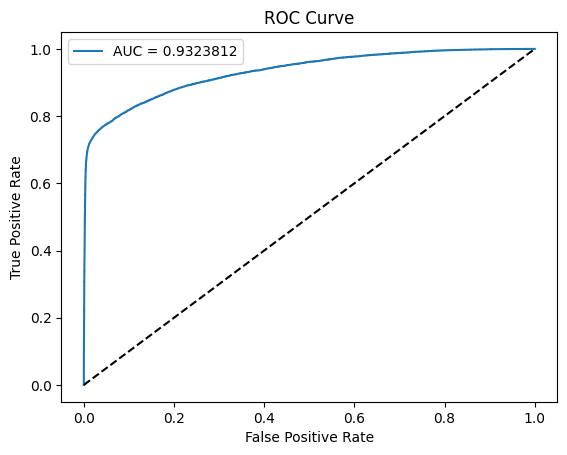

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve 

# Calculate AUC
fpr, tpr, thresholds  = roc_curve(train[target], oof)
auc = roc_auc_score(train[target], oof)
# Plot ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.7f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
# save the oof for inspection
oofer = train.loc[:,[target]].copy()
oofer[target] = oof
oofer.to_csv('oofv1.csv' , index=True)

# save the softmaxed oof for inspection
oofsmer = train.loc[:,[target]].copy()
oofsmer[target] = oofsm
oofsmer.to_csv('oofsmv1.csv' , index = True)

# build a submission
setout = pd.read_csv("/kaggle/input/playground-series-s4e10/sample_submission.csv")
setout[target] = outs
setout.to_csv("submission.csv", index=False)

In [17]:
!head /kaggle/working/submission.csv

id,loan_status
58645,0.99118894
58646,0.041345716
58647,0.2814354
58648,0.02126211
58649,0.113522224
58650,0.9217069
58651,0.0007730291
58652,0.013913701
58653,0.17146665


In [18]:
#this is with only one dataset -- obsolete info...
from io import StringIO as SO
jun = SO('''nnl1,nnl2,nnl3,nnl4,Folds,Epochs,Batch,Steps,LL,LLSM,AUC,LB,LR1,LRM1,LR2,LRM2,LR3,LRM3,ACT,Stops
64,128,128,64,12,12,64,840,0.17536744,1.869635836,,,0.004,2,0.001,7,0.0005,5,'relu',6 to 9
64,256,256,128,12,12,64,840,0.17542175,1.862260547,.9304,93470,0.004,2,0.001,7,0.0005,5,'relu', 3 to 7 
128,256,256,128,12,12,128,420,0.175576069,1.85918751,0.9301,0.93392,0.004,2,0.001,7,0.0005,5,'relu', 3 to 10 
128,256,512,128,12,12,128,420,0.178457176,1.919419,0.928,,0.002,2,0.001,9,0.0005,5,'relu', 3 to 10 
256,256,256,256,12,12,128,420,0.176362974,1.87824034,0.9301,,0.002,2,0.001,10,,,'relu', 3 to 9 
96,192,192,192,12,12,64,840,0.17497970941520888,1.866562798921456,0.9301,,0.004,2,0.001,10,,,'relu', 3 to 9 
128,256,256,128,12,12,128,840,0.17953036848404766,1.9077414974817908,0.9302,0.93246,0.003,2,0.002,2,0.001,10,'tanh', 5 to 12 
64,128,,128,12,12,128,840,0.1767506723207522,1.875167,0.92946,,0.003,2,0.002,2,0.001,10,'tanh', 5 to 12 
256,512,512,256,12,12,128,840,0.18031288003121398,1.9046684602757964,0.9252,,0.003,2,0.002,2,0.001,10,'tanh', 5 to 12 
256,512,512,256,12,12,128,840,0.1762869982833868,1.863489,.928328,,0.003,2,0.002,2,0.001,10,'elu', 5 to 12 
256,512,512,256,12,30,128,840,0.17300000261123938,1.863489761715461,.933739,,0.002,2,0.001,2,0.0005,22,'elu',  

''')
ccs = "nnl1,nnl2,nnl3,nnl4,Folds,Epochs,Batch,Steps,LL,LLSM,AUC,LB,LR1,LRM1,LR2,LRM2,LR3,LRM3,ACT,Stops".split(',')
print(len(ccs))
stats = pd.read_csv( jun , sep=",")
stats.columns = ccs
stats.head()
stats.to_csv('stats.csv')


20


In [19]:
stats

,nnl1,nnl2,nnl3,nnl4,Folds,Epochs,Batch,Steps,LL,LLSM,AUC,LB,LR1,LRM1,LR2,LRM2,LR3,LRM3,ACT,Stops
0,64,128,128.0,64,12,12,64,840,0.175367,1.869636,NaN,NaN,0.004,2,0.001,7,0.0005,5.0,'relu',6 to 9
1,64,256,256.0,128,12,12,64,840,0.175422,1.862261,0.930400,93470.00000,0.004,2,0.001,7,0.0005,5.0,'relu',3 to 7
2,128,256,256.0,128,12,12,128,420,0.175576,1.859188,0.930100,0.93392,0.004,2,0.001,7,0.0005,5.0,'relu',3 to 10
3,128,256,512.0,128,12,12,128,420,0.178457,1.919419,0.928000,NaN,0.002,2,0.001,9,0.0005,5.0,'relu',3 to 10
4,256,256,256.0,256,12,12,128,420,0.176363,1.878240,0.930100,NaN,0.002,2,0.001,10,NaN,NaN,'relu',3 to 9
5,96,192,192.0,192,12,12,64,840,0.174980,1.866563,0.930100,NaN,0.004,2,0.001,10,NaN,NaN,'relu',3 to 9
6,128,256,256.0,128,12,12,128,840,0.179530,1.907741,0.930200,0.93246,0.003,2,0.002,2,0.0010,10.0,'tanh',5 to 12
7,64,128,NaN,128,12,12,128,840,0.176751,1.875167,0.929460,NaN,0.003,2,0.002,2,0.0010,10.0,'tanh',5 to 12
8,256,512,512.0,256,12,12,128,840,0.180313,1.904668,0.925200,NaN,0.003,2,0.002,2,0.0010,10.0,'tanh',5 to 12
9,256,512,512.0,256,12,12,128,840,0.176287,1.863489,0.928328,NaN,0.003,2,0.002,2,0.0010,10.0,'elu',5 to 12


In [20]:
# stas = pd.read_csv('/kaggle/working/stats.csv')
# stats.to_clipboard()


In [21]:
!head /kaggle/working/submission.csv


id,loan_status
58645,0.99118894
58646,0.041345716
58647,0.2814354
58648,0.02126211
58649,0.113522224
58650,0.9217069
58651,0.0007730291
58652,0.013913701
58653,0.17146665
